In [209]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

# Loading and preprocessing data

In [210]:
data = pd.read_csv('data/dataset.csv')
features = data[['value', 'predicted']].to_numpy()
labels = data['is_anomaly'].to_numpy()

In [211]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
X_train = torch.tensor(X_train[y_train == False], dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

dl = DataLoader(X_train, batch_size=256, shuffle=True)

# Visualizing the data

In [212]:
def plot_datapoints(X: np.ndarray, y: np.ndarray):
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(8)
    ax.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

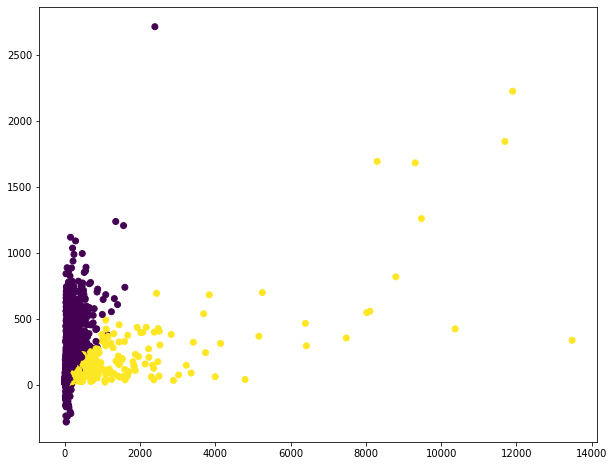

In [213]:
plot_datapoints(features, labels)

# Building and training a model

In [214]:
class AutoencoderAnomaly(nn.Module):
    def __init__(self):
        super(AutoencoderAnomaly, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 2**6),
            nn.ReLU(),
            nn.Linear(2**6, 2**5),
            nn.ReLU(),
            nn.Linear(2**5, 2**4),
            nn.ReLU(),
            nn.Linear(2**4, 2**3),
            nn.ReLU(),
            nn.Linear(2**3, 2**2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2**2, 2**3),
            nn.ReLU(),
            nn.Linear(2**3, 2**4),
            nn.ReLU(),
            nn.Linear(2**4, 2**5),
            nn.ReLU(),
            nn.Linear(2**5, 2**6),
            nn.ReLU(),
            nn.Linear(2**6, 2)
        )
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = self.encoder(X)
        return self.decoder(X)

In [215]:
model = AutoencoderAnomaly()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00007)
criterion = nn.MSELoss()

In [216]:
for epoch in range(1500):
    loss_num = 0
    for batch in dl:
        pred = model(batch)
        loss = criterion(pred, batch)
        loss_num += loss.detach()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'{epoch}) Loss: {loss_num}')

0) Loss: 530887.9375
1) Loss: 537339.25
2) Loss: 535006.25
3) Loss: 542490.0
4) Loss: 514869.09375
5) Loss: 485671.6875
6) Loss: 423466.5
7) Loss: 315316.65625
8) Loss: 174079.03125
9) Loss: 71101.7421875
10) Loss: 50798.265625
11) Loss: 50145.6015625
12) Loss: 51112.5546875
13) Loss: 49567.046875
14) Loss: 49706.31640625
15) Loss: 49322.6640625
16) Loss: 49297.20703125
17) Loss: 49954.84375
18) Loss: 49630.66796875
19) Loss: 49875.15625
20) Loss: 49739.5625
21) Loss: 49070.64453125
22) Loss: 49096.3984375
23) Loss: 49016.9375
24) Loss: 61586.78125
25) Loss: 49373.37890625
26) Loss: 49101.4609375
27) Loss: 48947.4609375
28) Loss: 49263.203125
29) Loss: 52988.515625
30) Loss: 49297.3359375
31) Loss: 49073.90234375
32) Loss: 52441.3125
33) Loss: 49218.25390625
34) Loss: 48977.49609375
35) Loss: 48799.578125
36) Loss: 51824.18359375
37) Loss: 49225.7734375
38) Loss: 49677.9453125
39) Loss: 48847.85546875
40) Loss: 48957.13671875
41) Loss: 48741.59765625
42) Loss: 49176.97265625
43) Loss: 

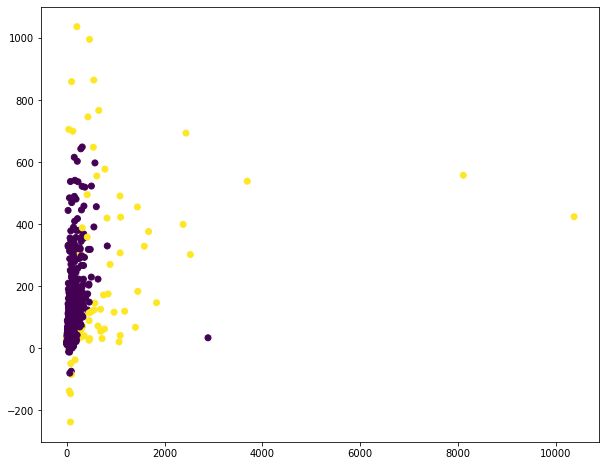

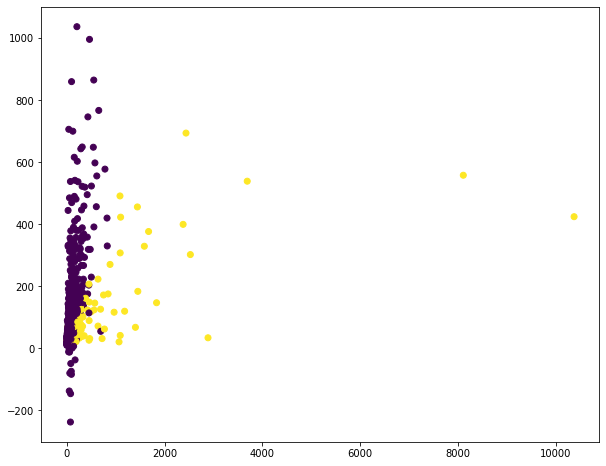

0.3508771929824562

In [239]:
with torch.inference_mode():
    loss_nums = np.array([criterion(model(x), x) for x in X_test])
loss_nums[loss_nums >= 0.03] = 100.
loss_nums[loss_nums != 100] = -100.
plot_datapoints(X_test, loss_nums)
plot_datapoints(X_test, y_test)

loss_nums[loss_nums == -100] = False
loss_nums[loss_nums == 100] = True
f1_score(y_test, loss_nums)